In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import warnings
warnings.filterwarnings("ignore")

# 0. Leitura dos Dados

In [2]:
client = boto3.client('s3')
client.download_file(Bucket=config_classifier['bucket_name'], Key='bitcoin/part-00000-a456c75c-7ccc-4db5-bd30-c4d135abc456-c000.snappy.parquet', Filename='file.snappy.parquet')

In [3]:
# Carregar dados (ajuste o caminho do arquivo)
df = pd.read_parquet('file.snappy.parquet')

In [4]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [5]:
def generate_features(df):
    df = df.copy()
    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # features baseadas em janelas de tempo
    df['log_return_1d'] = np.log(df['Close'] / df['Close'].shift(1))
    for win in [7, 30, 90, 180]:
        df[f'rolling_mean_{win}'] = df['Close'].rolling(win).mean()
        df[f'rolling_std_{win}'] = df['Close'].rolling(win).std()
        df[f'rolling_max_{win}'] = df['Close'].rolling(win).max()
        df[f'rolling_min_{win}'] = df['Close'].rolling(win).min()
        df[f'zscore_{win}'] = (df['Close'] - df[f'rolling_mean_{win}']) / (df[f'rolling_std_{win}'] + 1e-9)

    # features baseadas em momento de mercado
    df['momentum_3d'] = df['Close'] - df['Close'].shift(3)
    df['momentum_7d'] = df['Close'] - df['Close'].shift(7)

    # features baseadas em RSI (sugestão do chatGPT) em uma janela de 14 dias.
    #O RSI varia entre 0 e 100, e indica:
     #   RSI > 70 → ativo sobrecomprado - pode indicar que o preço vai corrigir para baixo
     #   RSI < 30 → ativo sobrevendido - pode indicar que o preço vai subir em breve
     #   RSI entre 30 e 70 → zona neutra.
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # janela móvel do volume dos ultimos 7 dias
    df['volume_mean_7'] = df['Volume'].rolling(7).mean()

    #A variável volume_spike mede o quanto o volume negociado em um dia está acima ou abaixo da média recente — ou seja, ela identifica “picos” (spikes) ou quedas de volume.
    df['volume_spike'] = df['Volume'] / (df['volume_mean_7'] + 1e-9)

    #A variável position_in_range_30 indica onde o preço de fechamento do dia atual está localizado dentro da faixa dos últimos 30 dias.
    df['position_in_range_30'] = (df['Close'] - df['rolling_min_30']) / (df['rolling_max_30'] - df['rolling_min_30'] + 1e-9)

    # Construção da target "dia bom para entrar" (subida de 5% em até 3 dias)
    df['future_max_3d'] = df['Close'].shift(-1).rolling(3).max()
    df['target'] = (df['future_max_3d'] >= df['Close'] * 1.05).astype(int)

    # Remover colunas temporárias e dados NA
    df.drop(columns=['future_max_3d', 'volume_mean_7'], inplace=True)
    df.dropna(inplace=True)

    return df

In [6]:
# Gerar features e target
df = generate_features(df)

# 1. Analise Exploratória de Dados

## 1.1 Verificando os Big Numbers do Bitcoin

### 1.1.1 Quantidade/Porcentagem de vezes que o Bitcoin subiu o valor

In [7]:
df.target.value_counts(normalize=True)

target
0    0.880432
1    0.119568
Name: proportion, dtype: float64

In [8]:
df.target.value_counts()

target
0    3262
1     443
Name: count, dtype: int64

### 1.1.2 Quantidade de Linhas e Colunas

In [9]:
df.shape

(3705, 33)

### 1.1.3 Período disponível

In [10]:
print('Início: ', df['Date'].min(), 'Fim: ',df['Date'].max())

Início:  2015-03-15 00:00:00 Fim:  2025-05-05 00:00:00


### 1.1.4 Quantidade de dados por ano

In [11]:
df['ano'] = df['Date'].str[0:4]

In [12]:
df.groupby(['ano'])['ano'].count()

ano
2015    292
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024    366
2025    125
Name: ano, dtype: int64

## 1.2 Valores máximos, mímimos e desvio padrão das variáveis principais (Abertura, Máxima, Fechamento)

In [13]:
print('Valores de Abertura (USD) \n Máximo: ', df['Open'].max(), '\n Mínimo: ', df['Open'].min(), '\n STD: ', df['Open'].std())

Valores de Abertura (USD) 
 Máximo:  106147.296875 
 Mínimo:  210.0679931640625 
 STD:  25381.278438225563


In [14]:
print('Valores de Máxima (USD) \n Máximo: ', df['High'].max(), '\n Mínimo: ', df['High'].min(), '\n STD: ', df['High'].std())

Valores de Máxima (USD) 
 Máximo:  109114.8828125 
 Mínimo:  223.8329925537109 
 STD:  25912.10544592036


In [15]:
print('Valores de Fechamento (USD) \n Máximo: ', df['Close'].max(), '\n Mínimo: ', df['Close'].min(), '\n STD: ', df['Close'].std())

Valores de Fechamento (USD) 
 Máximo:  106146.265625 
 Mínimo:  210.4949951171875 
 STD:  25404.674815533046


## 1.3 Crescimento do Volume

In [16]:
df['datetime'] = pd.to_datetime(df['Date'])

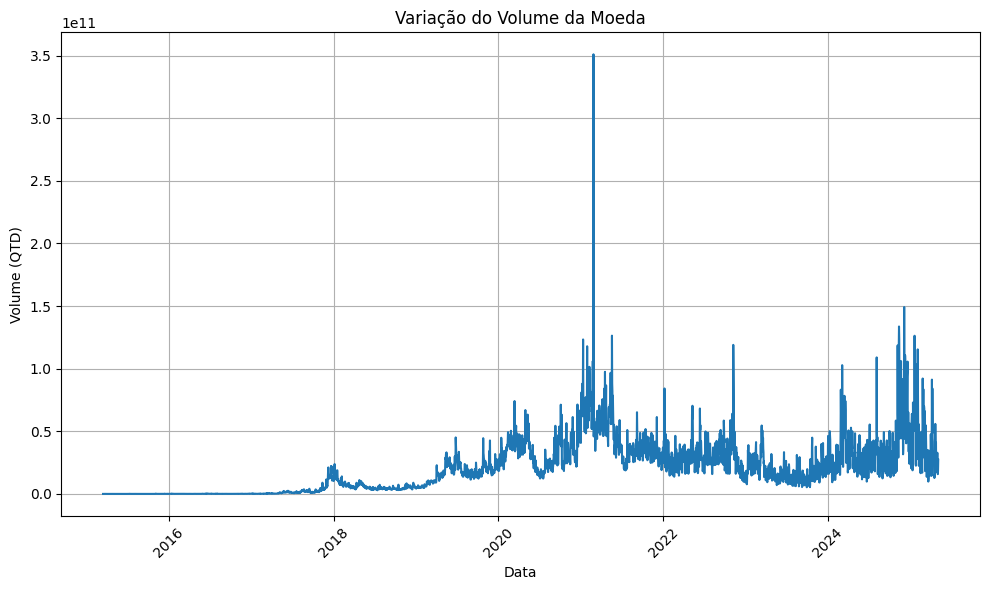

In [17]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="Volume")

plt.title("Variação do Volume da Moeda")
plt.xlabel("Data")
plt.ylabel("Volume (QTD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.4 Crescimento do Valor (Fechamento)

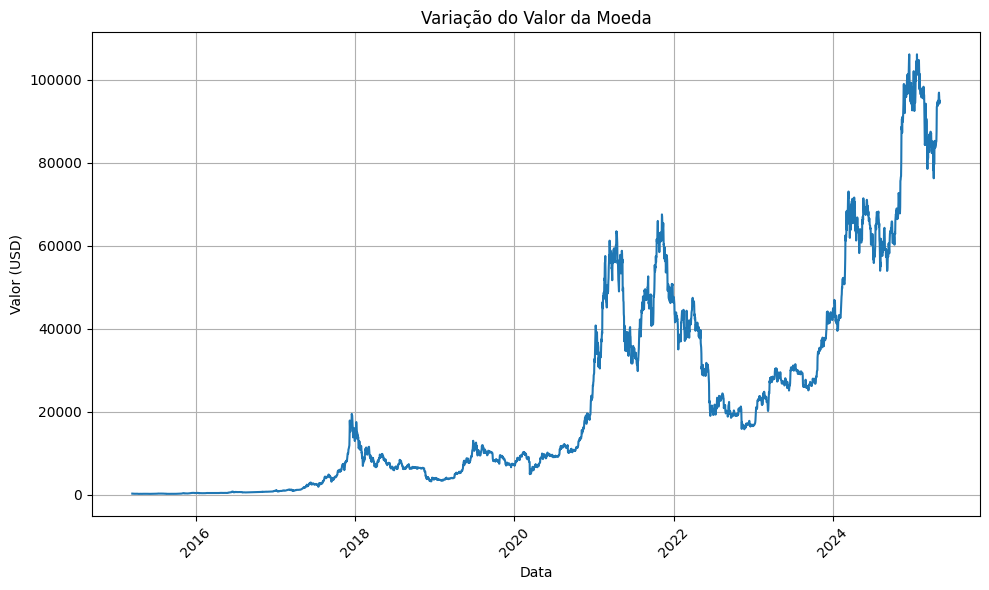

In [18]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="Close")

plt.title("Variação do Valor da Moeda")
plt.xlabel("Data")
plt.ylabel("Valor (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.5 Crescimento do Market Cap

In [19]:
df['market_cap'] = df['Close']*df['Volume']

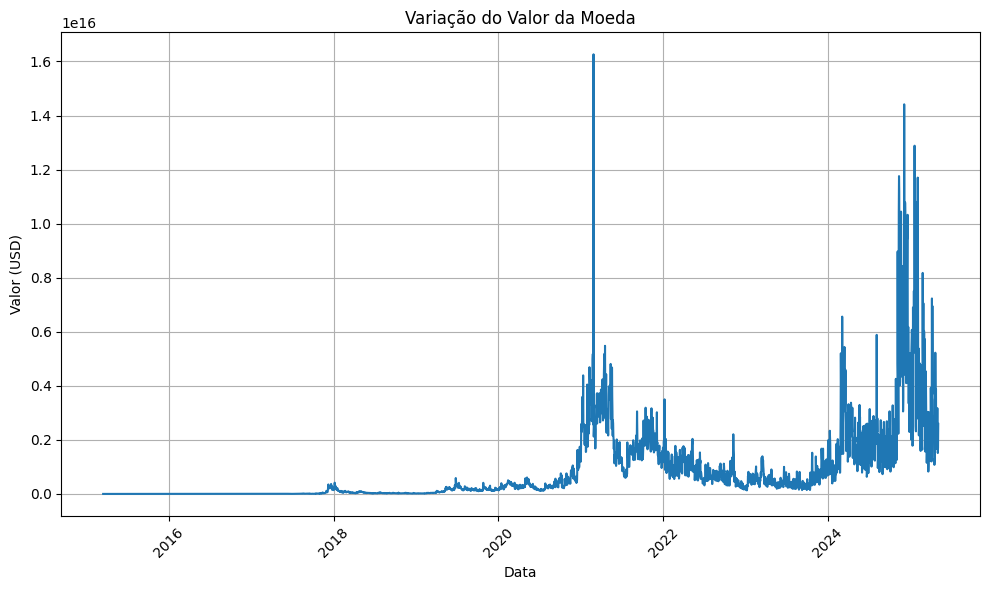

In [20]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="market_cap")

plt.title("Variação do Valor da Moeda")
plt.xlabel("Data")
plt.ylabel("Valor (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.6 Boxplot da target pelo valor de fechamento

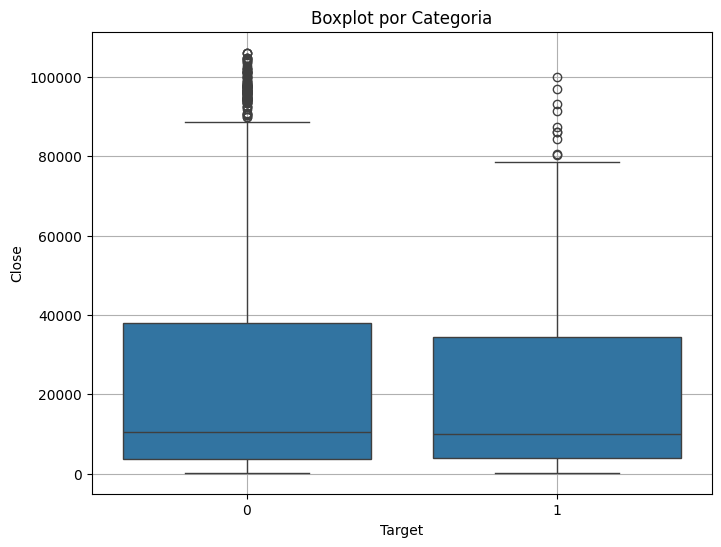

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="target", y="Close", data=df)

plt.title("Boxplot por Categoria")
plt.xlabel("Target")
plt.ylabel("Close")
plt.grid(True)
plt.show()

## 1.4 Crescimento do Valor de Momento de mercado 7 dias

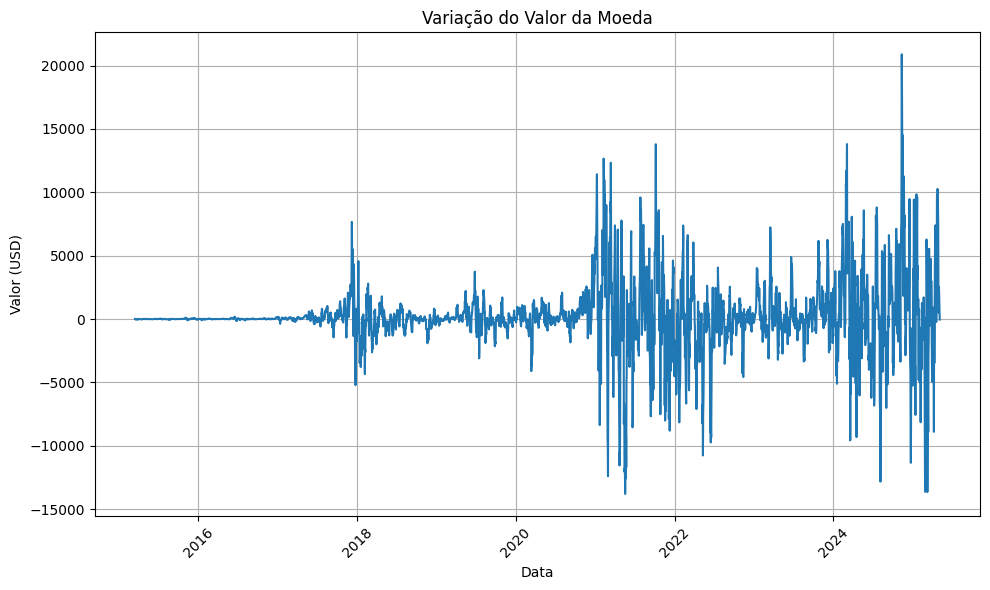

In [22]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="momentum_7d")

plt.title("Variação do Valor da Moeda")
plt.xlabel("Data")
plt.ylabel("Valor (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()